# Taxi v3 usando HRL (MAXQ-0)

Arbol de acciones 

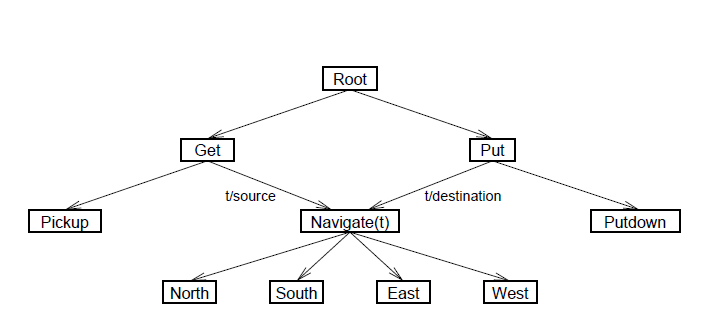

In [30]:
# Importación de librerias necesarias para el funcionamiento del código
import numpy as np
import gymnasium as gym
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Definición de la clase Agent
class Agent:
    # Método constructor de la clase
    def __init__(self, env, alpha, gamma, epsilon):
        self.env = env # Instanciación del entorno para el agente
        
        # Definición de las acciones no primitivas
        not_pr_acts = 2 + 1 + 1 + 1   # gotoS,D + put + get + root (non primitive actions)
        nA = self.env.action_space.n + not_pr_acts # Total de acciones (primitivas + no primitivas).    
        nS = self.env.observation_space.n # Total de estados en el entorno
        self.V = np.zeros((nA, nS)) # Valor de estado-acción para todas las acciones en todos los estados
        self.C = np.zeros((nA, nS, nA)) # Correlación jerárquica entre las acciones de alto nivel y sus subacciones
        self.V_copy = self.V.copy() # Copia de respaldo de V para evaluaciones
        
        # Define índices para cada acción (primitivas y no primitivas).
        s = self.south = 0 
        n = self.north = 1
        e = self.east = 2
        w = self.west = 3
        pickup = self.pickup = 4
        dropoff = self.dropoff = 5
        gotoS = self.gotoS = 6
        gotoD = self.gotoD = 7
        get = self.get = 8
        put = self.put = 9
        root = self.root = 10
        

        self.graph = [
            set(),  # south
            set(),  # north
            set(),  # east
            set(),  # west
            set(),  # pickup
            set(),  # dropoff
            {s, n, e, w},  # gotoSource
            {s, n, e, w},  # gotoDestination
            {pickup, gotoS},  # get -> pickup, gotoSource
            {dropoff, gotoD},  # put -> dropoff, gotoDestination
            {put, get},  # root -> put, get
        ]
        
        # Definición de los hiperparámetros para el agente
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Inicialización de variables de estado para el agente
        self.r_sum = 0 # Suma de recompensas
        self.new_s = 0  # Nuevo estado
        self.done = False # Flag para indicar si el episodio ha terminado
        self.truncated = False # Flag para indicar si el episodio ha sido truncado
        self.num_of_ac = 0 # Número de acciones realizadas


    def is_primitive(self, act):
        '''Función que verifica si una acción es primitiva'''
        return act <= 5
    
    def is_terminal(self, a, done):
        ''' Función que verifica si una acción es terminal'''
        try:
            RGBY = [(0, 0), (0, 4), (4, 0), (4, 3)] # Posiciones de los pasajeros
            taxirow, taxicol, passidx, destidx = list(self.env.unwrapped.decode(self.env.unwrapped.s)) # Decodificación del estado
            taxiloc = (taxirow, taxicol) # Posición del taxi
            
            if done or self.truncated: # Comprueba si el episodio ha terminado o ha sido truncado
                return True
            elif a == self.root: # Comprueba si la acción es la raíz
                return done
            elif a == self.put: # Comprueba si la acción es put
                return passidx < 4
            elif a == self.get: # Comprueba si la acción es get
                return passidx >= 4
            elif a == self.gotoD: # Comprueba si la acción es gotoDestination
                return passidx >= 4 and taxiloc == RGBY[destidx]
            elif a == self.gotoS: # Comprueba si la acción es gotoSource
                return passidx < 4 and taxiloc == RGBY[passidx]
            elif self.is_primitive(a): # Comprueba si la acción es primitiva
                return True
            return False
        except Exception as e:
            print(f"Error in is_terminal: {e}")
            return True  # Safe default
        
    def evaluate(self, act, s):
        '''Función que evalúa el valor de una acción no primitiva'''
        try:
            if self.is_primitive(act): # Comprueba si la acción es primitiva
                return self.V_copy[act, s] # Retorna el valor de la acción
            else:
                for j in self.graph[act]: # Itera sobre las acciones del grafo
                    self.V_copy[j, s] = self.evaluate(j, s) # Evalúa el valor de la acción
                Q = np.array([]) # Inicialización de un arreglo vacío
                for a2 in self.graph[act]: # Itera sobre las acciones del grafo
                    Q = np.append(Q, self.V_copy[a2, s]) # Agrega el valor de la acción al arreglo
                if len(Q) > 0: # Comprueba si el arreglo no está vacío
                    max_arg = np.argmax(Q) # Obtiene el índice del valor máximo
                    return self.V_copy[list(self.graph[act])[max_arg], s] # Retorna el valor máximo
                return 0.0
        except Exception as e:
            print(f"Error in evaluate: {e}")
            return 0.0  # Safe default
            
    def greed_act(self, act, s):
        '''Función que elige una acción de forma "codiciosa" usando una política epsilon-greedy'''
        try:
            e = self.epsilon # Epsilon para la política epsilon-greedy
            Q = np.array([]) 
            possible_a = np.array([])
            for act2 in self.graph[act]: # Itera sobre las acciones del grafo
                if self.is_primitive(act2) or (not self.is_terminal(act2, self.done)): # Comprueba si la acción es primitiva o no terminal
                    Q = np.append(Q, self.V[act2, s] + self.C[act, s, act2]) # Agrega el valor de la acción al arreglo
                    possible_a = np.append(possible_a, act2) # Agrega la acción al arreglo
            
            if len(possible_a) == 0: # Comprueba si el arreglo de acciones posibles está vacío
                return 0
                
            max_arg = np.argmax(Q) # Obtiene el índice del valor máximo
            if np.random.rand() < e: # Comprueba si el valor aleatorio es menor que epsilon
                return int(np.random.choice(possible_a)) # Retorna una acción aleatoria
            else:
                return int(possible_a[max_arg]) # Retorna la acción codiciosa
        except Exception as e:
            print(f"Error in greed_act: {e}")
            return 0
        
    def MAXQ_0(self, i, s):
        ''' Función que implementa el algoritmo MAXQ-0 para aprendizaje jerárquico'''
        try:
            if self.done or self.truncated: # Comprueba si el episodio ha terminado o ha sido truncado
                return 0
                
            if self.is_primitive(i): # Comprueba si la acción es primitiva
                observation, r, self.done, self.truncated, _ = self.env.step(i) # Ejecuta la acción primitiva i en el entorno usando env.step(i)
                self.new_s = observation # Actualiza el nuevo estado (self.new_s) con el estado resultante
                self.r_sum += r # Acumula la recompensa recibida en self.r_sum
                self.num_of_ac += 1 # Incrementa el contador de acciones realizadas (self.num_of_ac).
                self.V[i, s] += self.alpha * (r - self.V[i, s]) # Actualiza el valor de la acción primitiva usando la fórmula de aprendizaje
                return 1 # Devuelve 1, indicando que se ejecutó una acción primitiva
            elif i <= self.root: # Si la acción no es primitiva y es menor o igual a la raíz (root), significa que es jerárquica 
                count = 0 # Inicia un contador para registrar cuántas acciones primitivas se ejecutan durante la resolución de la acción jerárquica
                while not self.is_terminal(i, self.done): # Ejecuta las subacciones hasta que la acción jerárquica sea terminal
                    a = self.greed_act(i, s) # Elige una subacción a de forma "codiciosa" usando la función greed_act, que implementa una política epsilon-greedy.
                    N = self.MAXQ_0(a, s) # Llama recursivamente a MAXQ_0 con la subacción a y el estado actual s. Esto resuelve la subacción, devolviendo el número de acciones primitivas ejecutadas (N).

                    # el código tiene en cuenta posibles casos extremos como la división por cero o resultados inesperados del entorno
                    if N is None:  # Verifica si N es None (en caso de errores) y lo establece en 0 como valor seguro (Rubrica)
                        N = 0
                    self.V_copy = self.V.copy() # Actualiza la copia de respaldo de V para evaluaciones
                    evaluate_res = self.evaluate(i, self.new_s) # valúa el valor de la acción jerárquica i en el nuevo estado self.new_s
                    self.C[i, s, a] += self.alpha * (self.gamma ** N * evaluate_res - self.C[i, s, a]) # Actualiza el valor de la correlación jerárquica entre la acción i y su subacción a
                    count += N # Incrementa el contador de acciones primitivas ejecutadas
                    s = self.new_s # Actualiza el estado actual s al nuevo estado self.new_s.
                return count # Devuelve el número total de acciones primitivas ejecutadas para resolver la acción jerárquica i
            return 0  # Safe default for any other case
        except Exception as e:
            print(f"Error in MAXQ_0: {e}") # Captura y muestra errores durante la ejecución
            return 0  # Safe default
        
    def reset(self):
        ''' Función que reinicia el entorno y las variables de estado del agente'''
        observation, _ = self.env.reset()
        self.new_s = observation
        self.r_sum = 0
        self.num_of_ac = 0
        self.done = False
        self.truncated = False


def train_and_plot(episodes=10000, alphax=0.2, gammax=1, epsilonx=0.001):
    try:
        alpha = alphax
        gamma = gammax
        epsilon = epsilonx
        env = gym.make('Taxi-v3', render_mode=None)
        taxi = Agent(env, alpha, gamma, epsilon)
        sum_list = []    # Lista para recompensas
        steps_list = []  # Lista para número de pasos
        
        for j in range(episodes):
            taxi.reset()
            N = taxi.MAXQ_0(10, env.unwrapped.s)
            sum_list.append(taxi.r_sum)
            steps_list.append(taxi.num_of_ac)  # Guardamos el número de acciones/pasos
            if (j % 1000 == 0):
                print(f'already made {j} episodes, last N={N}, reward={taxi.r_sum}, steps={taxi.num_of_ac}')

        # Configuración del estilo de la gráfica
        sns.set(style='darkgrid')
        sns.set(font_scale=1.5)
        
        # Crear una figura con dos subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        
        # Título general con los hiperparámetros
        fig.suptitle(f'Entrenamiento MAXQ-0\nα={alpha}, γ={gamma}, ε={epsilon}, Episodes={episodes}', 
                    fontsize=16, y=0.95)
        
        # Subplot para recompensas
        ax1.plot(sum_list)
        ax1.set_xlabel('Num episodios')
        ax1.set_ylabel('Recompensa')
        ax1.set_title('Recompensa por episodio')
        
        # Subplot para pasos
        ax2.plot(steps_list, color='orange')
        ax2.set_xlabel('Num episodios')
        ax2.set_ylabel('Número de pasos')
        ax2.set_title('Pasos por episodio')
        
        # Ajustar el diseño
        plt.tight_layout()
        plt.show()
        
        # Hiperparámetros
        print(f"\nHiperparámetros usados: α={alpha}, γ={gamma}, ε={epsilon}")

        # Calcular algunas estadísticas básicas
        print("\nEstadísticas:")
        print(f"Recompensa promedio últimos 1000 episodios: {np.mean(sum_list[-1000:]):.2f}")
        print(f"Pasos promedio últimos 1000 episodios: {np.mean(steps_list[-1000:]):.2f}")
        print(f"Recompensa mínima: {min(sum_list)}")
        print(f"Recompensa máxima: {max(sum_list)}")
        print(f"Pasos mínimos: {min(steps_list)}")
        print(f"Pasos máximos: {max(steps_list)}")
        
        return taxi, sum_list, steps_list
    except Exception as e:
        print(f"Error in train_and_plot: {e}")
        return None, None, None


### Entrenamiento 

already made 0 episodes, last N=75, reward=-63, steps=75
already made 1000 episodes, last N=24, reward=-3, steps=24
already made 2000 episodes, last N=18, reward=3, steps=18
already made 3000 episodes, last N=10, reward=11, steps=10
already made 4000 episodes, last N=14, reward=7, steps=14
already made 5000 episodes, last N=16, reward=5, steps=16
already made 6000 episodes, last N=10, reward=11, steps=10
already made 7000 episodes, last N=12, reward=9, steps=12
already made 8000 episodes, last N=14, reward=7, steps=14
already made 9000 episodes, last N=10, reward=11, steps=10


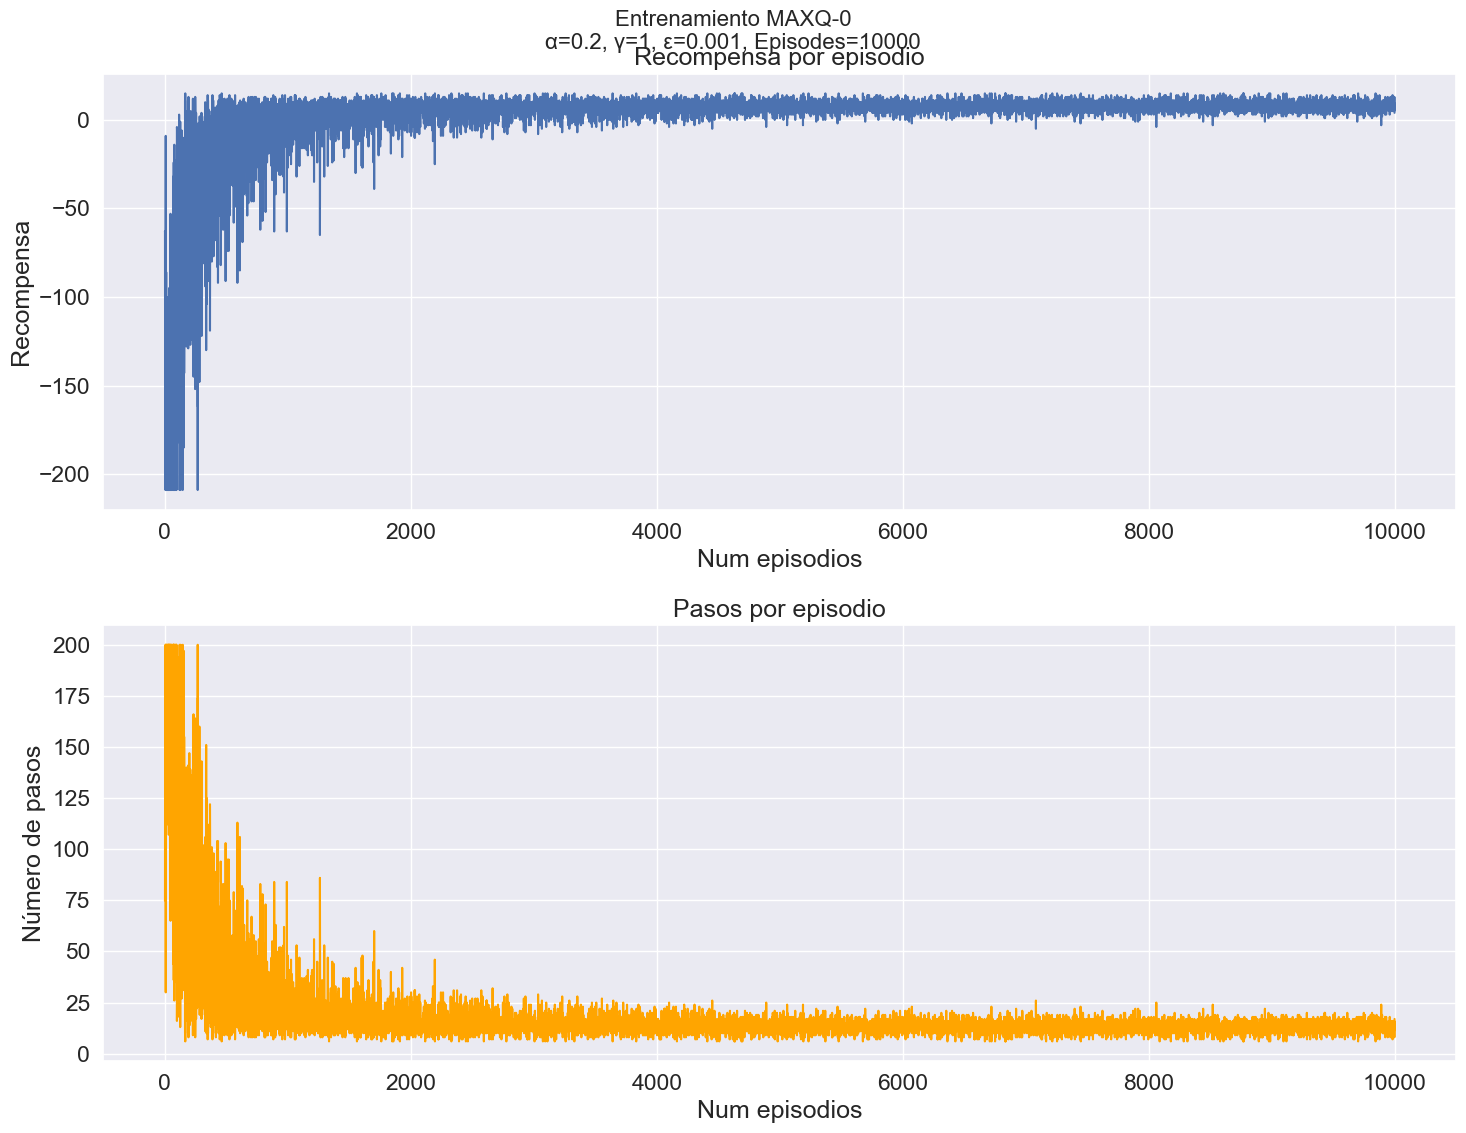


Hiperparámetros usados: α=0.2, γ=1, ε=0.001

Estadísticas:
Recompensa promedio últimos 1000 episodios: 7.70
Pasos promedio últimos 1000 episodios: 13.28
Recompensa mínima: -209
Recompensa máxima: 15
Pasos mínimos: 6
Pasos máximos: 200


In [31]:
trained_agent, rewards, steps = train_and_plot(10000, 0.2, 1, 0.001) # Entrenamiento del agente y visualización de la recompensa acumulada en cada episodio

already made 0 episodes, last N=90, reward=-78, steps=90
already made 1000 episodes, last N=59, reward=-38, steps=59
already made 2000 episodes, last N=12, reward=9, steps=12
already made 3000 episodes, last N=21, reward=0, steps=21
already made 4000 episodes, last N=12, reward=9, steps=12
already made 5000 episodes, last N=12, reward=9, steps=12
already made 6000 episodes, last N=15, reward=6, steps=15
already made 7000 episodes, last N=10, reward=11, steps=10
already made 8000 episodes, last N=13, reward=8, steps=13
already made 9000 episodes, last N=20, reward=1, steps=20


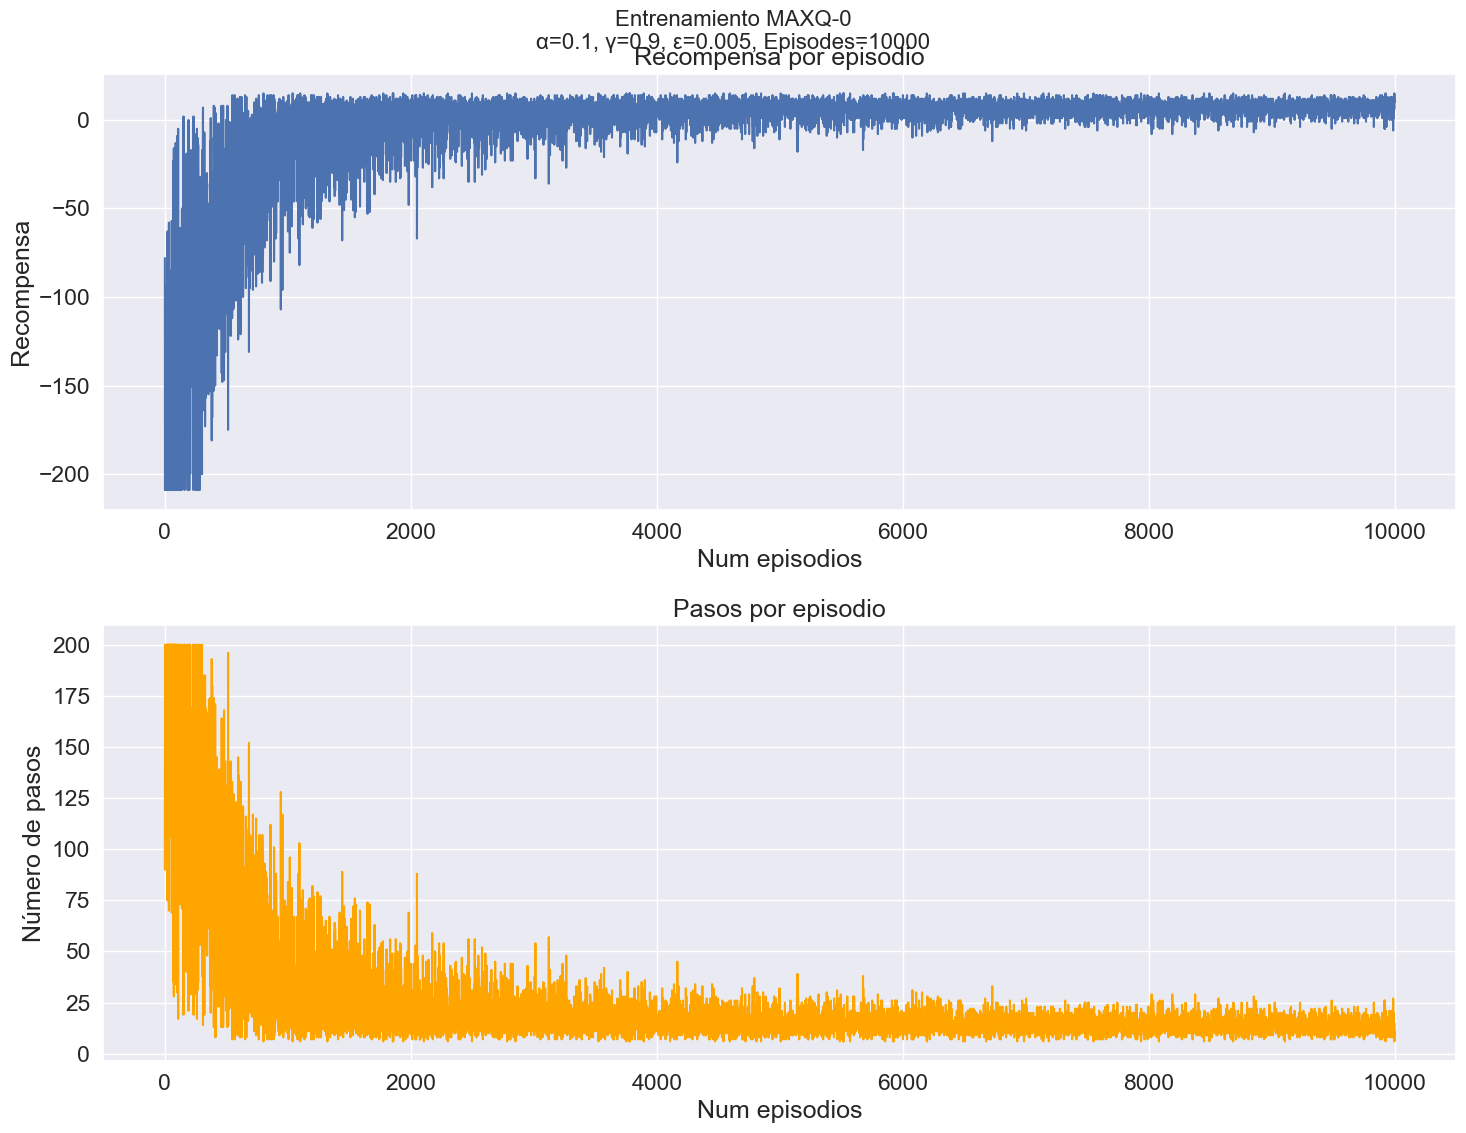


Hiperparámetros usados: α=0.1, γ=0.9, ε=0.005

Estadísticas:
Recompensa promedio últimos 1000 episodios: 7.17
Pasos promedio últimos 1000 episodios: 13.82
Recompensa mínima: -209
Recompensa máxima: 15
Pasos mínimos: 6
Pasos máximos: 200


In [32]:
trained_agent, rewards, steps = train_and_plot(10000, 0.1, 0.9, 0.005) # Entrenamiento del agente y visualización de la recompensa acumulada en cada episodio

already made 0 episodes, last N=123, reward=-102, steps=123
already made 1000 episodes, last N=49, reward=-28, steps=49
already made 2000 episodes, last N=12, reward=9, steps=12
already made 3000 episodes, last N=6, reward=15, steps=6
already made 4000 episodes, last N=200, reward=-200, steps=200
already made 5000 episodes, last N=10, reward=11, steps=10
already made 6000 episodes, last N=16, reward=5, steps=16
already made 7000 episodes, last N=7, reward=14, steps=7
already made 8000 episodes, last N=15, reward=6, steps=15
already made 9000 episodes, last N=200, reward=-200, steps=200


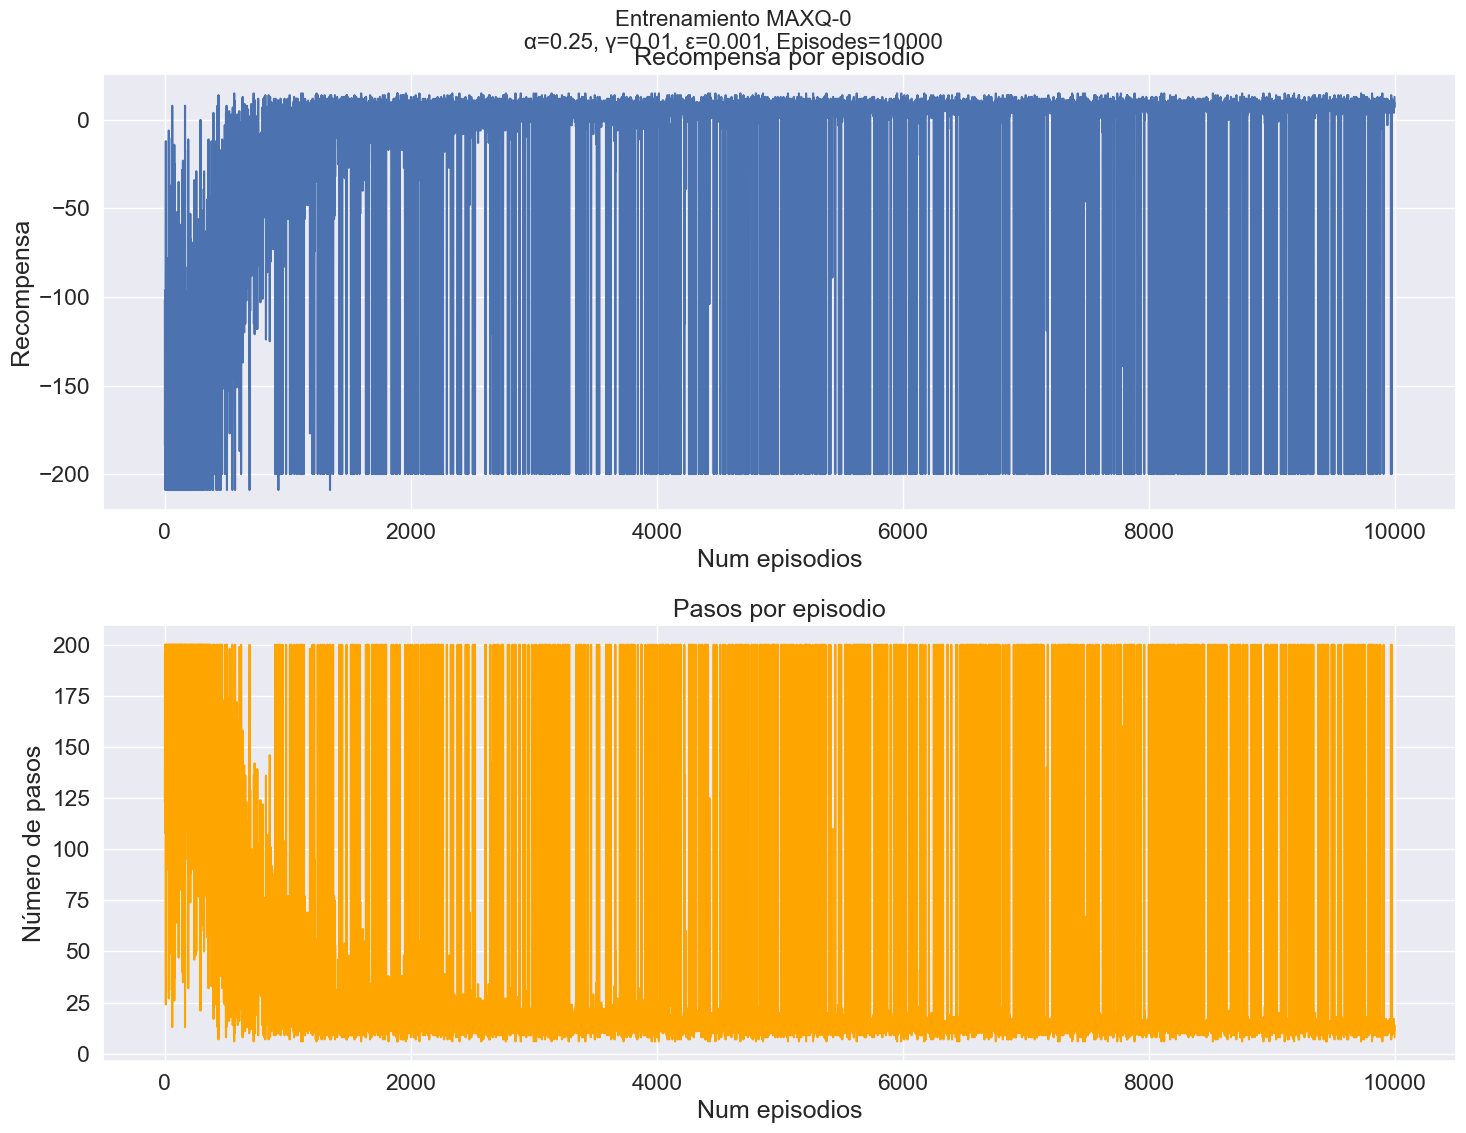


Hiperparámetros usados: α=0.25, γ=0.01, ε=0.001

Estadísticas:
Recompensa promedio últimos 1000 episodios: -12.42
Pasos promedio últimos 1000 episodios: 31.38
Recompensa mínima: -209
Recompensa máxima: 15
Pasos mínimos: 6
Pasos máximos: 200


In [35]:
trained_agent, rewards, steps = train_and_plot(10000, 0.25, 0.01, 0.001) # Entrenamiento del agente y visualización de la recompensa acumulada en cada episodio

already made 0 episodes, last N=130, reward=-118, steps=130
already made 1000 episodes, last N=15, reward=-3, steps=15
already made 2000 episodes, last N=14, reward=7, steps=14
already made 3000 episodes, last N=14, reward=7, steps=14
already made 4000 episodes, last N=14, reward=7, steps=14
already made 5000 episodes, last N=21, reward=0, steps=21
already made 6000 episodes, last N=15, reward=6, steps=15
already made 7000 episodes, last N=16, reward=5, steps=16
already made 8000 episodes, last N=15, reward=6, steps=15
already made 9000 episodes, last N=11, reward=10, steps=11


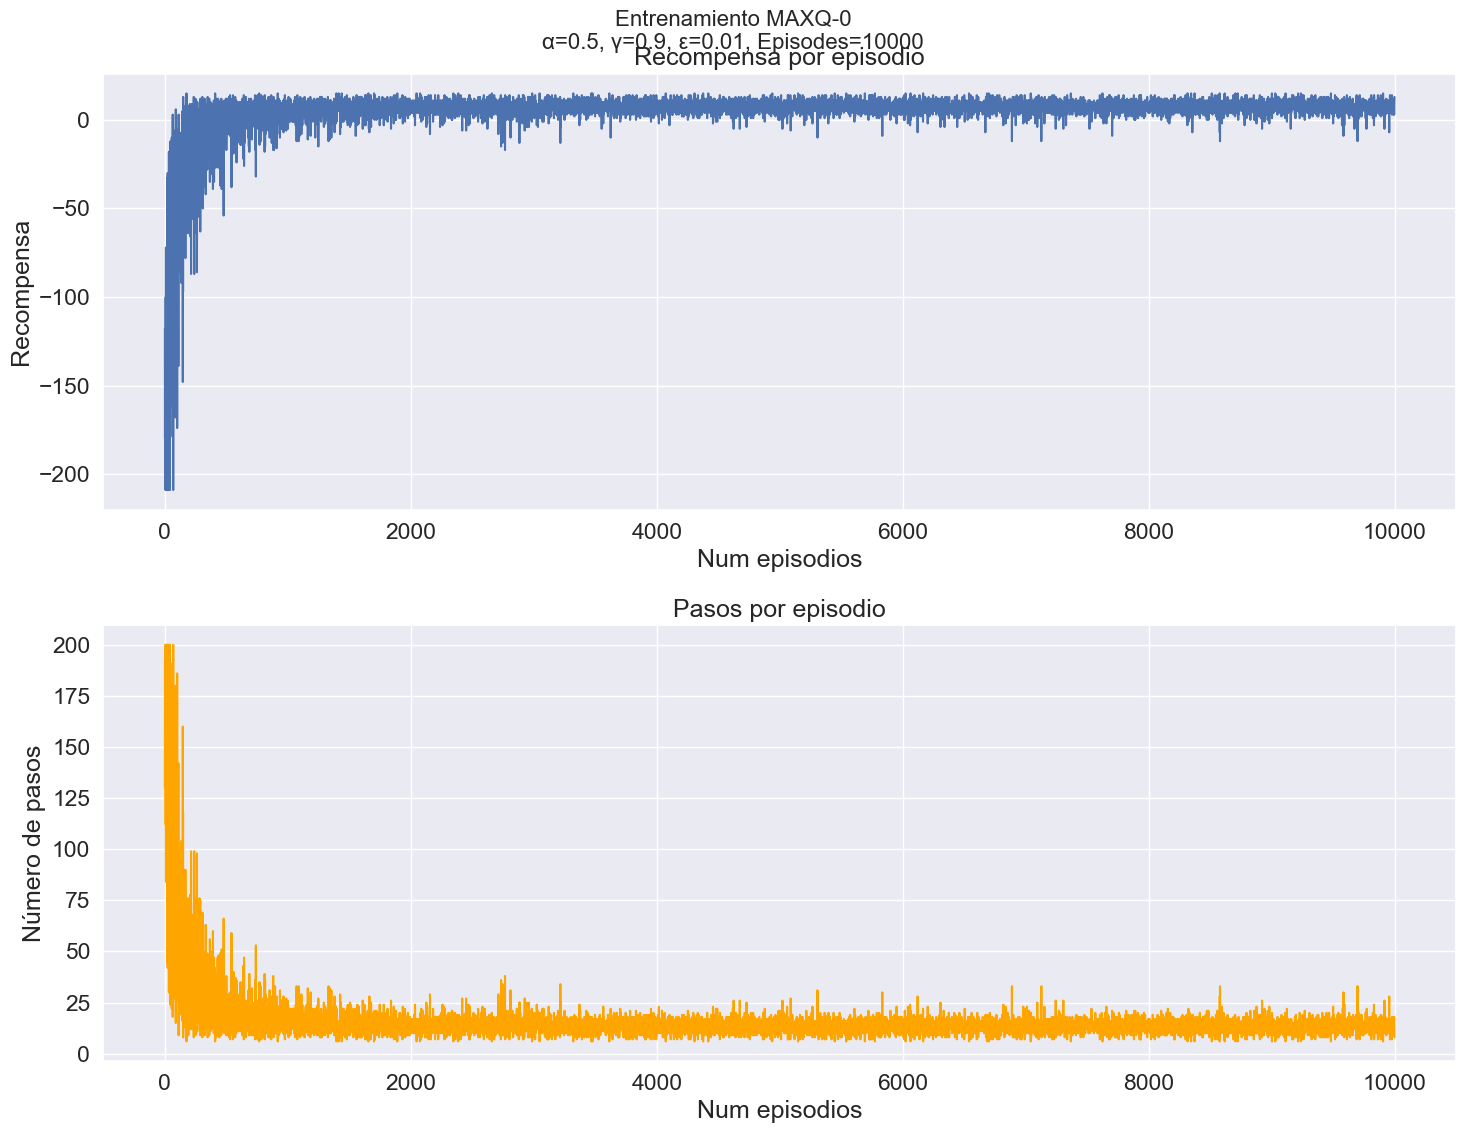


Hiperparámetros usados: α=0.5, γ=0.9, ε=0.01

Estadísticas:
Recompensa promedio últimos 1000 episodios: 7.41
Pasos promedio últimos 1000 episodios: 13.52
Recompensa mínima: -209
Recompensa máxima: 15
Pasos mínimos: 6
Pasos máximos: 200


In [33]:
trained_agent, rewards, steps = train_and_plot(10000, 0.5, 0.9, 0.01) # Entrenamiento del agente y visualización de la recompensa acumulada en cada episodio

### Prueba del agente entrenado

In [36]:
import gymnasium as gym
import time
import IPython.display as display
from IPython.display import HTML
import numpy as np

def decode_taxi_locations(env):
    """
    Decodifica y retorna información sobre las ubicaciones en el entorno del taxi
    """
    RGBY_LOCATIONS = [(0, 0), (0, 4), (4, 0), (4, 3)]
    LOCATION_NAMES = {
        (0, 0): 'R (Rojo)',
        (0, 4): 'G (Verde)',
        (4, 0): 'Y (Amarillo)',
        (4, 3): 'B (Azul)'
    }
    
    taxirow, taxicol, passidx, destidx = list(env.unwrapped.decode(env.unwrapped.s))
    
    # Ubicación del taxi
    taxi_loc = (taxirow, taxicol)
    
    # Ubicación del pasajero (puede estar en una ubicación RGBY o en el taxi)
    if passidx < 4:
        passenger_loc = RGBY_LOCATIONS[passidx]
        passenger_status = f"en {LOCATION_NAMES[passenger_loc]}"
    else:
        passenger_status = "en el taxi"
        
    # Ubicación del destino
    dest_loc = RGBY_LOCATIONS[destidx]
    
    return {
        'taxi': taxi_loc,
        'passenger_loc': passenger_status,
        'destination': LOCATION_NAMES[dest_loc]
    }

def simulate_taxi(agent, max_steps=100, sleep_time=0.5):
    """
    Simula y visualiza el comportamiento del taxi usando el agente entrenado
    mostrando todos los pasos primitivos
    """
    # Crear entorno con modo de renderizado
    env = gym.make('Taxi-v3', render_mode='ansi')
    observation, _ = env.reset()
    
    # Inicializar el agente
    agent.env = env
    agent.reset()
    
    # Obtener y mostrar información inicial de ubicaciones
    locations = decode_taxi_locations(env)
    print("\n=== Información del Estado Inicial ===")
    print(f"Pasajero: {locations['passenger_loc']}")
    print(f"Destino: {locations['destination']}")
    print("=====================================\n")
    
    total_reward = 0
    step = 0
    actions_taken = []
    
    # Diccionario para mapear números de acción a nombres
    action_names = {
        0: "Sur",
        1: "Norte",
        2: "Este",
        3: "Oeste",
        4: "Recoger",
        5: "Dejar",
        6: "Ir a Fuente",
        7: "Ir a Destino",
        8: "Obtener",
        9: "Poner",
        10: "Raíz"
    }
    
    def execute_action(action, current_state):
        """Ejecuta una acción y todas sus subacciones recursivamente"""
        nonlocal step, total_reward
        
        if agent.is_primitive(action):
            # Si es una acción primitiva, ejecutarla directamente
            observation, reward, done, truncated, _ = env.step(action)
            agent.new_s = observation
            agent.done = done
            agent.truncated = truncated
            total_reward += reward
            
            # Registrar la acción y mostrar el estado
            actions_taken.append(action_names.get(action, f"Acción {action}"))
            print(f"\nPaso {step + 1}:")
            print(f"Acción: {action_names.get(action, action)}")
            print(env.render())
            
            # Si la acción es recoger o dejar, mostrar el nuevo estado del pasajero
            if action in [4, 5]:  # pickup o dropoff
                new_locations = decode_taxi_locations(env)
                print(f"Estado del pasajero: {new_locations['passenger_loc']}")
            
            step += 1
            time.sleep(sleep_time)
            
            return observation
        else:
            # Si es una acción compuesta, ejecutar sus subacciones
            while not agent.is_terminal(action, agent.done):
                next_action = agent.greed_act(action, current_state)
                current_state = execute_action(next_action, current_state)
            return current_state
    
    print("Estado Inicial:")
    print(env.render())
    
    # Ejecutar la política desde la raíz
    current_state = env.unwrapped.s
    while not (agent.done or agent.truncated) and step < max_steps:
        action = agent.greed_act(agent.root, current_state)
        current_state = execute_action(action, current_state)
        
        if agent.done or agent.truncated:
            break
    
    if agent.done:
        print("\n¡Tarea completada!")
    elif agent.truncated:
        print("\nEpisodio truncado")
    else:
        print("\nMáximo de pasos alcanzado")
    
    print(f"\nResumen del episodio:")
    print(f"Pasos totales: {step}")
    print(f"Recompensa total: {total_reward}")
    print("\nSecuencia de acciones:")
    for i, action in enumerate(actions_taken, 1):
        print(f"{i}. {action}")
    
    env.close()
    return total_reward, step, actions_taken

def plot_episode_stats(rewards, steps):
    """
    Grafica las estadísticas de múltiples episodios
    """
    plt.figure(figsize=(15, 5))
    
    # Subplot para recompensas
    plt.subplot(1, 2, 1)
    plt.plot(rewards, 'b-')
    plt.title('Recompensas por Episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa Total')
    
    # Subplot para pasos
    plt.subplot(1, 2, 2)
    plt.plot(steps, 'r-')
    plt.title('Pasos por Episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Número de Pasos')
    
    plt.tight_layout()
    plt.show()

def run_multiple_episodes(agent, num_episodes=5):
    """
    Ejecuta múltiples episodios y registra las estadísticas
    """
    all_rewards = []
    all_steps = []
    all_actions = []
    
    for episode in range(num_episodes):
        print(f"\n=== Episodio {episode + 1} ===")
        reward, steps, actions = simulate_taxi(agent)
        all_rewards.append(reward)
        all_steps.append(steps)
        all_actions.append(actions)
    
    # Graficar estadísticas
    plot_episode_stats(all_rewards, all_steps)
    
    return all_rewards, all_steps, all_actions

In [37]:
# Simula un episodio completo
reward, steps, actions = simulate_taxi(trained_agent)


=== Información del Estado Inicial ===
Pasajero: en Y (Amarillo)
Destino: B (Azul)

Estado Inicial:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Paso 1:
Acción: Sur
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


Paso 2:
Acción: Sur
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


Paso 3:
Acción: Oeste
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


Paso 4:
Acción: Sur
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


Paso 5:
Acción: Sur
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


Paso 6:
Acción: Recoger
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Estado del pasajero: en el taxi

Paso 7:
Acción: Norte
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | 